In [1]:
from dotenv import load_dotenv
import os
load_dotenv()

True

In [2]:
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["GOOGLE_API_KEY"]=os.getenv("GOOGLE_API_KEY")


In [3]:
from langchain_groq import ChatGroq
from langchain_google_genai import GoogleGenerativeAIEmbeddings

llm = ChatGroq(model="deepseek-r1-distill-llama-70b")
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

## Data Ingestion

In [4]:
urls=[
    "https://lilianweng.github.io/posts/2023-01-27-the-transformer-family-v2/",
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    ]

In [5]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [6]:
docs = [WebBaseLoader(url).load() for url in urls]

In [7]:
complete_docs = [item for doc in docs for item in doc]

In [8]:
complete_docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-01-27-the-transformer-family-v2/', 'title': "The Transformer Family Version 2.0 | Lil'Log", 'description': 'Many new Transformer architecture improvements have been proposed since my last post on “The Transformer Family” about three years ago. Here I did a big refactoring and enrichment of that 2020 post — restructure the hierarchy of sections and improve many sections with more recent papers. Version 2.0 is a superset of the old version, about twice the length.\nNotations\n\n  \n      \n          Symbol\n          Meaning\n      \n  \n  \n      \n          $d$\n          The model size / hidden state dimension / positional encoding size.\n      \n      \n          $h$\n          The number of heads in multi-head attention layer.\n      \n      \n          $L$\n          The segment length of input sequence.\n      \n      \n          $N$\n          The total number of attention layers in the model; not considering 

In [9]:
splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=100,chunk_overlap=25)
splitted_docs = splitter.split_documents(complete_docs)
splitted_docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-01-27-the-transformer-family-v2/', 'title': "The Transformer Family Version 2.0 | Lil'Log", 'description': 'Many new Transformer architecture improvements have been proposed since my last post on “The Transformer Family” about three years ago. Here I did a big refactoring and enrichment of that 2020 post — restructure the hierarchy of sections and improve many sections with more recent papers. Version 2.0 is a superset of the old version, about twice the length.\nNotations\n\n  \n      \n          Symbol\n          Meaning\n      \n  \n  \n      \n          $d$\n          The model size / hidden state dimension / positional encoding size.\n      \n      \n          $h$\n          The number of heads in multi-head attention layer.\n      \n      \n          $L$\n          The segment length of input sequence.\n      \n      \n          $N$\n          The total number of attention layers in the model; not considering 

In [10]:
len(splitted_docs)

637

## Retriever Pipeline using Chromadb

In [11]:
from langchain.vectorstores import Chroma
vectorStore = Chroma.from_documents(
    documents=splitted_docs,
    collection_name="corrective-rag-chroma",
    embedding=embeddings,
)

In [12]:
retriever = vectorStore.as_retriever(search_kwargs={"k":3})

In [13]:
retriever.invoke("What is agent?")

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.', 'language': 'en', 'title': "Prompt Engineering | Lil'Log"}, page_content='Definition: Determine the speaker of the dialogue, "agent" or "customer".\nInput: I have successfully booked your tickets.\nOuput: agent'),
 Document(metadata={'description':

## Tavily search

In [14]:
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
from langchain_community.tools import TavilySearchResults
search = TavilySearchResults(tavily_api_key= TAVILY_API_KEY)

/var/folders/8g/sz3w79_54bgdwgjzjt0tn92h0000gn/T/ipykernel_4596/3371011542.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search = TavilySearchResults(tavily_api_key= TAVILY_API_KEY)


## Create Retriever as tool

In [15]:
from langchain.tools.retriever import create_retriever_tool
retriever_tool = create_retriever_tool(
    retriever,
    "corrective-rag-retriever",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and Transformers.You are a specialized assistant. Use the 'retriever_tool' **only** when the query explicitly relates to LangChain blog data. For all other queries, respond directly without using any tool. For simple queries like 'hi', 'hello', or 'how are you', provide a normal response.",
)

In [16]:
tools = [retriever_tool]
from langgraph.prebuilt import ToolNode

retriever_node = ToolNode(tools)

## Creating workflow


In [17]:
from langgraph.graph import StateGraph,END,START
from pydantic import BaseModel,Field
from langchain_core.messages import BaseMessage,HumanMessage
from langgraph.prebuilt import tools_condition
from langchain_core.prompts import PromptTemplate
from langgraph.graph.message import add_messages
from typing import TypedDict,Annotated,Sequence

In [18]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage],add_messages]

In [19]:
class Grade(BaseModel):
    score: str = Field(description="Relevance score 'yes' or 'no'")

In [20]:
llm_with_tool = llm.bind_tools(tools)

In [21]:
def llm_decision_func(state:AgentState):
    print("--->LLM CALL<---")
    question = state["messages"][-1].content
    res = llm_with_tool.invoke(question)
    return {"messages":[res]}

In [22]:
from langchain_core.output_parsers import PydanticOutputParser
parser = PydanticOutputParser(pydantic_object=Grade)

In [23]:
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"score": {"description": "Relevance score \'yes\' or \'no\'", "title": "Score", "type": "string"}}, "required": ["score"]}\n```'

In [24]:
def grader_func(state:AgentState):
    print("--->GRADER FUNCTION<---")
    question = state["messages"][0].content
    context = state["messages"][-1].content
    llm_with_structure_op=llm.with_structured_output(Grade)
    prompt=PromptTemplate(
        template="""You are a grader deciding if a document is relevant to a user’s question.
                    Here is the document: {context}
                    Here is the user’s question: {question}
                    If the document talks about or contains information related to the user’s question, mark it as relevant. 
                    Give a 'yes' or 'no' answer to show if the document is relevant to the question.""",
                    input_variables=["context", "question"]
                    )
    chain = prompt | llm_with_structure_op

    result = chain.invoke({"question":question,"context":context})
    print("RESULT in grader!!!@##^&%R&%-----:",result)
    score = result.score

    if score=="yes":
        print("---DECISION: DOCS ARE RELEVANT---")
        return "generator"
    print("---DECISION: DOCS ARE NOT RELEVANT---")
    return "rewriter"


In [25]:
from langchain import hub

In [26]:
def generator(state:AgentState):
    print("--->RAG O/P GENERATOR<---")
    docs = state["messages"][-1].content
    question = state["messages"][0].content

    prompt = hub.pull("rlm/rag-prompt")

    rag_chain = prompt|llm

    res = rag_chain.invoke({"context":docs,"question":question})

    print(f"My response:---> {res}")

    return {"messages":[res]} 

    

In [27]:
def rewriter(state:AgentState):
    print("---> Re-Writer--->")
    question = state["messages"][0].content

    input= [HumanMessage(content=f"""Look at the input and try to reason about the underlying semantic intent or meaning. 
                    Here is the initial question: {question} 
                    Formulate an improved question: """)
       ]

    res = llm.invoke(input)
    return {"messages":[res]}

In [28]:
def webSearch(state:AgentState):
    print("--->WEB SEARCH<---")
    question = state["messages"][-1].content

    res = search.invoke({"query":question})

    print(f"Web search response---->: {res}")

    return {"messages":[res[0].get("content")]}




In [29]:
workflow = StateGraph(AgentState)

In [30]:
workflow.add_node("LLM DECIDER",llm_decision_func)
workflow.add_node("RETRIEVER",retriever_node)
workflow.add_node("GENERATOR",generator)
workflow.add_node("RE-WRITER",rewriter)
workflow.add_node("WEB SEARCH",webSearch)

In [31]:
workflow.add_edge(START,"LLM DECIDER")
workflow.add_conditional_edges("LLM DECIDER",
                               tools_condition,
                               {
                                   "tools":"RETRIEVER",
                                   END:END
                               })
workflow.add_conditional_edges("RETRIEVER",
                               grader_func,
                               {
                                  "generator": "GENERATOR",
                                  "rewriter":"RE-WRITER"
                               })
workflow.add_edge("GENERATOR",END)
workflow.add_edge("RE-WRITER","WEB SEARCH")
workflow.add_edge("WEB SEARCH",END)

In [32]:
app = workflow.compile()

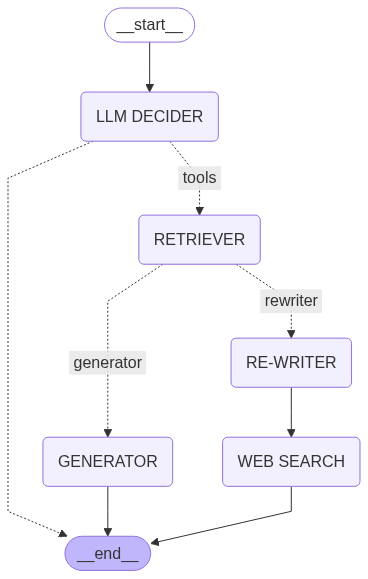

In [33]:
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

In [34]:
app.invoke({"messages":["what is LLM Powered Autonomous Agents?"]})

--->LLM CALL<---


{'messages': [HumanMessage(content='what is LLM Powered Autonomous Agents?', additional_kwargs={}, response_metadata={}, id='a741c645-8244-4f88-ab23-2f6ad7466716'),
  AIMessage(content='LLM-powered autonomous agents are advanced artificial intelligence systems that utilize large language models (LLMs) to perform tasks independently. These agents can understand and respond to commands, solve problems, and even learn from interactions to improve their performance over time. They are capable of handling complex tasks, providing assistance, and making decisions without human intervention. Examples include sophisticated chatbots, virtual assistants, and automated problem-solving systems. These agents leverage the power of LLMs to generate responses, process information, and adapt to various scenarios, making them highly versatile and efficient in a wide range of applications.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 347, 'prompt_tokens': 221, 'total_to

In [35]:
app.invoke({"messages":["what is LLM Powered Autonomous Agents explain the planning and reflection and prompt engineering explain me in terms of agents and langchain?"]})

--->LLM CALL<---
--->GRADER FUNCTION<---
RESULT in grader!!!@##^&%R&%-----: score='yes'
---DECISION: DOCS ARE RELEVANT---
--->RAG O/P GENERATOR<---
My response:---> content="<think>\nOkay, so I need to figure out what LLM Powered Autonomous Agents are and explain their planning and reflection, as well as prompt engineering in terms of agents and LangChain. Let me break this down.\n\nFirst, I know that LLM stands for Large Language Model. So, LLM-powered autonomous agents must be agents that use these models to function. The context mentions that the LLM serves as the agent’s brain, along with components like NLP, alignment, steerability, and prompting. \n\nPlanning in this context probably refers to how the agent breaks down tasks. The context talks about task decomposition, which is splitting a big task into smaller parts. So, planning would involve the agent figuring out the steps needed to achieve a goal.\n\nReflection is about self-reflection, as mentioned. This likely means the ag

{'messages': [HumanMessage(content='what is LLM Powered Autonomous Agents explain the planning and reflection and prompt engineering explain me in terms of agents and langchain?', additional_kwargs={}, response_metadata={}, id='87aa0401-9c34-48f1-b914-8b84d89ca9ff'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '1af8hgjdm', 'function': {'arguments': '{"query":"LLM Powered Autonomous Agents planning and reflection and prompt engineering in terms of agents and LangChain"}', 'name': 'corrective-rag-retriever'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 333, 'prompt_tokens': 238, 'total_tokens': 571, 'completion_time': 1.581706101, 'prompt_time': 0.015250052, 'queue_time': 0.468306063, 'total_time': 1.596956153}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--87f4866f-ae80-4c0f-8882-23cfa1a296d3-0', tool_calls=[{'name': 'corrective-rag-r